# TO DO:


## - connect stepsize to framrate of animation (maybe write an animate function)
## - refine potential, so that only one entry of boxsize is needed at integrator
## - opensys?

-5.0


<IPython.core.display.Javascript object>


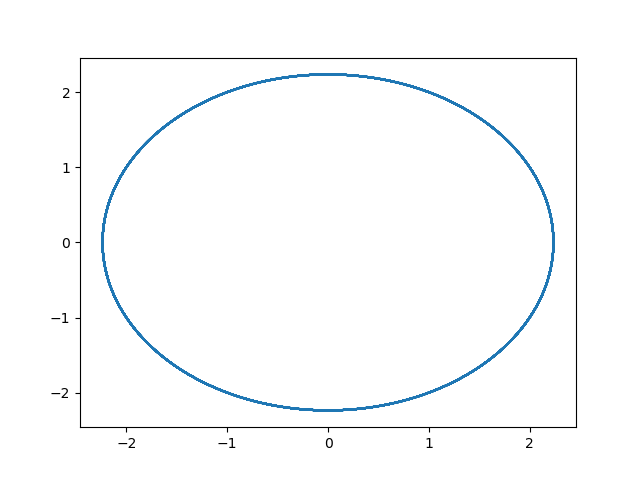

In [1]:
%matplotlib notebook
#%load_ext line_profiler
import numpy as np
from numba import jit
from potentials import *
from distances import *
from sampling import *
from Langevin import *
from Velocity_Verlet import *
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:

#Boxsizes must be customized!!!
def pot_gradient(coord, pbc=True,boxsize=(-20,20), sig=1, eps=1):
    vecs = vectors(coord, boxsize, pbc)
    return gradients.LJ(vecs, sig, eps) + gradients.harmonic(coord,boxsize, pbc, r0 =(0, 0), k=1)
def pot(coord, pbc=True,boxsize=(-20,20), sig=1, eps=1):
    vecs = vectors(coord, boxsize, pbc)
    dist = distances(vecs)
    return potentials.LJ(dist, eps, sig) + potentials.harmonic(coord, boxsize, pbc, r0 =(0, 0),k=1)

In [3]:
#orders particles in a circle
def circle(n_atoms, radius, velocity, toward_center=True, dim=2):
    r_init = np.zeros((n_atoms,dim))
    radius = 15
    for i in range(0,len(r_init)):
        angle = 2*np.pi/len(r_init)
        r_init[i] = [radius*np.cos(angle*i),radius*np.sin(angle*i)]    
    #let the particles travel towards the center
    if toward_center:
        sign=-1
    else:
        sign=1
    v_init = sign*velocity*r_init
    return r_init,v_init

In [38]:
                    #################################################################
                    ##########################             ###########################
                    #########################   SAMPLING    #########################
                    ########################                 #######################
                    #################################################################

#                                      MARKOV CHAIN MONTE CARLO

#usage:   mcmc(pot,n_atoms,dim,n_steps,stepsize, beta=1, boxsize=(0, 1), pbc=False)
#r_init = mcmc(pot, 24, 2, 5000, stepsize=0.01, beta=100, boxsize=(-20,20), pbc=True)


#initial values
r_init, v_init = circle(46, 15, 2, toward_center=True, dim=2)
boxsize = (-20, 20)


                    #################################################################
                    ########################                 ########################
                    #######################    INTEGRATION    #######################
                    #########################               #########################
                    #################################################################


#                                             VELOCITY VERLET

#usage:                      vv1(pot_gradient, r_init, v_init, m, T, timestep, boxsize, opensys=True, pbc=True)
#r_matrix, v_matrix, a_matrix=vv1(pot_gradient, r_init, v_init, 20, 2, 0.0001,(-20,20), opensys=False, pbc=True)

#                                                LANGEVIN

# usage:                        langevin(pot_gradient, r_init, v_init, m, T,timestep,damp,beta,boxsize, pbc=True)
r_matrix, v_matrix, a_matrix = langevin(pot_gradient, r_init, v_init, 20, 4, 0.0001, 0, 1, boxsize, True)

<IPython.core.display.Javascript object>


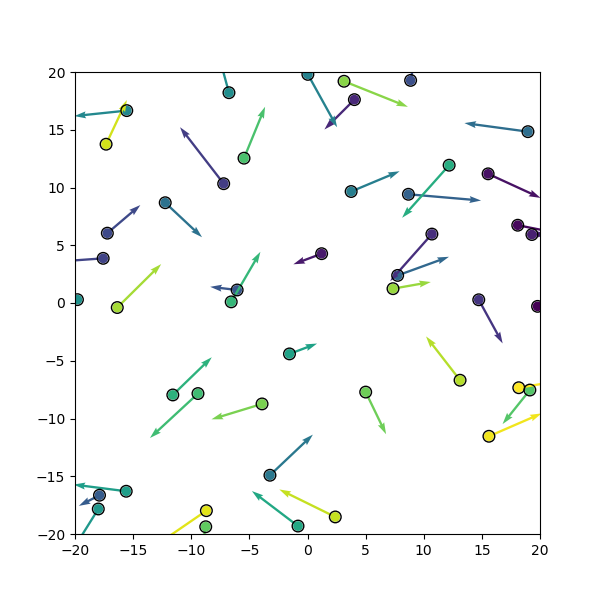

In [43]:
# TO DO: connect stepsize to framrate of animation (maybe write an animate function)


                    #################################################################
                    ########################                 ########################
                    #########################   ANIMATION   #########################
                    ##########################             ##########################
                    #################################################################
                    
arrow_scale = 2
boxmin = boxsize[0]
boxmax = boxsize[1]

fig, ax = plt.subplots(figsize=(6, 6))
colors = np.arange(len(r_init))
scat = ax.scatter(r_init[:,0], r_init[:,1], c=colors)
circles = [plt.Circle(r, radius=0.5, fill=False) for i,r in enumerate(r_init)]

for c in circles:
    plt.gca().add_patch(c)
qax = ax.quiver(r_matrix[0,:,0], r_matrix[0,:,1], v_matrix[1,:,0], v_matrix[1,:,1],np.arange(len(r_init)),scale=(arrow_scale/500)**-1, width=0.005)
ax.set_xlim(boxmin, boxmax)
ax.set_ylim(boxmin, boxmax)


def animate(i):
    index = 4*i
    data = r_matrix[index]
    scat.set_offsets(data)
    for i, c in enumerate(circles):
        c.center = data[i]
    qax.set_UVC(v_matrix[index,:,0],v_matrix[index,:,1])
    qax.set_offsets(data)
    return scat,


fps = 25
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps, bitrate=len(r_matrix)/(fps*4))
anim = animation.FuncAnimation(fig, animate, interval=5, frames=len(r_matrix), repeat=False)
#anim.save('46_particles_circle.mp4', writer=writer)